In [1]:
from collections.abc import Iterable

import numpy as np
import pandas as pd
import qubx  # type: ignore
from qubx.core.basics import DataType
from pprint import pprint as prn

%qubxd

%load_ext autoreload
%autoreload 2

# - - - - - - - - - -
from qubx.data.transformers import PandasFrame, TypedRecords, OHLCVSeries, TickSeries
from qubx.data.storages.questdb import QuestDBStorage


⠀⠀⡰⡖⠒⠒⢒⢦⠀⠀   
⠀⢠⠃⠈⢆⣀⣎⣀⣱⡀  QUBX | Quantitative Backtesting Environment 
⠀⢳⠒⠒⡞⠚⡄⠀⡰⠁         (c) 2025, ver. 0.6.84
⠀⠀⠱⣜⣀⣀⣈⣦⠃⠀⠀⠀ 
        


## Reading market data

In [15]:
Q = QuestDBStorage("quantlab", synthetic_ohlc_timeframes_types=True)

In [16]:
r = Q.get_reader("BINANCE.UM", "SWAP")

> What symbols does storage have for ordebook data ?

In [17]:
r.get_data_id("orderbook")[:10]

['1000000MOGUSDT',
 '1000BONKUSDT',
 '1000FLOKIUSDT',
 '1000PEPEUSDT',
 '1000SHIBUSDT',
 'AAVEUSDT',
 'ADAUSDT',
 'AEROUSDT',
 'ALGOUSDT',
 'APEUSDT']

> What data types available for symbol

In [18]:
prn(r.get_data_types("BTCUSDT"))

[funding_rate,
 open_interest,
 funding_payment,
 'ohlc(1min)',
 'ohlc(2min)',
 'ohlc(3min)',
 'ohlc(5min)',
 'ohlc(10min)',
 'ohlc(15min)',
 'ohlc(30min)',
 'ohlc(1h)',
 'ohlc(2h)',
 'ohlc(3h)',
 'ohlc(4h)',
 'ohlc(6h)',
 'ohlc(8h)',
 'ohlc(12h)',
 'ohlc(1d)',
 'ohlc(1w)',
 orderbook,
 'aggregated_liquidations(1min)',
 'aggregated_liquidations(2min)',
 'aggregated_liquidations(3min)',
 'aggregated_liquidations(5min)',
 'aggregated_liquidations(10min)',
 'aggregated_liquidations(15min)',
 'aggregated_liquidations(30min)',
 'aggregated_liquidations(1h)',
 'aggregated_liquidations(2h)',
 'aggregated_liquidations(3h)',
 'aggregated_liquidations(4h)',
 'aggregated_liquidations(6h)',
 'aggregated_liquidations(8h)',
 'aggregated_liquidations(12h)',
 'aggregated_liquidations(1d)',
 'aggregated_liquidations(1w)',
 'metrics']


> Read data for multiple symbols

In [21]:
data = r.read(["BTCUSDT", "ETHUSDT"], "ohlc(1h)", "2024-01-01", "now")

In [22]:
data

-[MULTI DATA]-
	 - ETHUSDT(ohlc(1h))[2024-01-01 00:00:00 : 2025-10-05 19:00:00]
	 - BTCUSDT(ohlc(1h))[2024-01-01 00:00:00 : 2025-10-05 19:00:00]

> Read by chunks 

In [23]:
data2 = r.read(["BTCUSDT", "ETHUSDT"], "ohlc(1h)", "2024-01-01", "now", chunksize=100)

In [24]:
assert isinstance(data2, Iterable)

for _ in range(3):
    prn(next(data2))

-[MULTI DATA]-
	 - ETHUSDT(ohlc(1h))[2024-01-01 00:00:00 : 2024-01-05 03:00:00]
	 - BTCUSDT(ohlc(1h))[2024-01-01 00:00:00 : 2024-01-05 03:00:00]
-[MULTI DATA]-
	 - ETHUSDT(ohlc(1h))[2024-01-05 04:00:00 : 2024-01-09 07:00:00]
	 - BTCUSDT(ohlc(1h))[2024-01-05 04:00:00 : 2024-01-09 07:00:00]
-[MULTI DATA]-
	 - ETHUSDT(ohlc(1h))[2024-01-09 08:00:00 : 2024-01-13 11:00:00]
	 - BTCUSDT(ohlc(1h))[2024-01-09 08:00:00 : 2024-01-13 11:00:00]


> Transformations

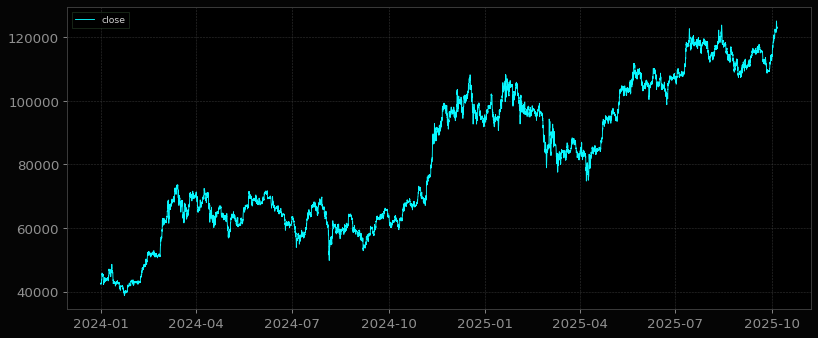

In [25]:
data.transform(OHLCVSeries())["BTCUSDT"].close.plot()

> Funding payments

In [26]:
fp = r.read(["BTCUSDT", "ETHUSDT"], DataType.FUNDING_PAYMENT, "2025-01-01", "now")
fp.transform(PandasFrame(True)).head(4)

funding_rate  funding_interval_hours
timestamp               symbol                                       
2025-01-01 00:00:00.015 BTCUSDT        0.0001                     8.0
                        ETHUSDT        0.0001                     8.0
2025-01-01 08:00:00.000 BTCUSDT        0.0001                     8.0
                        ETHUSDT        0.0001                     8.0

In [27]:
fp.transform(TypedRecords())["ETHUSDT"][:4]

[[2025-01-01T00:00:00.015000000]	 0.00010 (8.0H),
 [2025-01-01T08:00:00.000000000]	 0.00010 (8.0H),
 [2025-01-01T16:00:00.001000000]	 0.00010 (8.0H),
 [2025-01-02T00:00:00.000000000]	 0.00010 (8.0H)]

> Funding rates

In [28]:
fr = r.read(["BTCUSDT", "ETHUSDT"], DataType.FUNDING_RATE, "2025-01-01", "now")
fr.transform(PandasFrame(True)).head(4)

rate interval    next_funding_time  \
timestamp           symbol                                            
2025-09-29 14:45:00 BTCUSDT  0.000019       8h  1759161600000000000   
                    BTCUSDT  0.000019       8h  1759161600000000000   
                    BTCUSDT  0.000019       8h  1759161600000000000   
                    BTCUSDT  0.000019       8h  1759161600000000000   

                                mark_price    index_price  
timestamp           symbol                                 
2025-09-29 14:45:00 BTCUSDT  114030.000000  114084.382826  
                    BTCUSDT  114029.800000  114087.440870  
                    BTCUSDT  114005.451167  114072.503478  
                    BTCUSDT  114021.600000  114075.404130

In [29]:
fr.transform(TypedRecords())["ETHUSDT"][:4]

[[2025-09-29T14:45:00.000000000]	 -0.00003 (8h),
 [2025-09-29T14:45:00.000000000]	 -0.00003 (8h),
 [2025-09-29T14:45:00.000000000]	 -0.00003 (8h),
 [2025-09-29T14:45:00.000000000]	 -0.00003 (8h)]

> OrderBook

In [83]:
obd = r.read("BTCUSDT", DataType.ORDERBOOK, "2025-09-01", "2025-09-02")

In [90]:
obd.transform(PandasFrame())

,symbol,top_bid,top_ask,tick_size,bid_1,bid_2,bid_3,bid_4,bid_5,bid_6,...,ask_391,ask_392,ask_393,ask_394,ask_395,ask_396,ask_397,ask_398,ask_399,ask_400
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-09-01 00:00:00,BTCUSDT,108208.3,108208.4,10.8,9.645,21.974,26.132,38.494,31.060,21.804,...,0.161,0.036,0.468,0.155,0.292,0.172,1.034,13.472,0.973,2.778
2025-09-01 00:01:00,BTCUSDT,108226.1,108226.2,10.8,118.466,18.016,39.620,23.493,40.051,29.533,...,0.444,0.139,0.278,0.166,0.520,13.152,0.898,3.650,1.362,1.348
2025-09-01 00:02:00,BTCUSDT,108292.8,108292.9,10.8,53.357,27.581,29.973,33.417,26.274,25.007,...,0.964,2.692,1.323,1.351,14.973,2.348,2.099,0.564,1.685,1.674
2025-09-01 00:03:00,BTCUSDT,108215.2,108215.3,10.8,25.595,25.693,38.809,32.421,22.353,23.557,...,0.124,0.444,0.139,0.278,0.162,0.524,12.682,0.905,2.240,1.362
2025-09-01 00:04:00,BTCUSDT,108188.0,108188.1,10.8,18.046,26.671,42.652,25.584,33.541,25.442,...,0.067,0.066,0.155,0.438,0.029,0.153,0.302,0.172,0.615,12.973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-01 23:55:00,BTCUSDT,109078.7,109078.8,10.9,15.548,17.249,30.790,33.178,64.390,33.411,...,11.131,5.131,1.206,0.193,0.371,11.592,8.326,13.285,163.487,2.332
2025-09-01 23:56:00,BTCUSDT,109108.1,109108.2,10.9,26.079,26.760,25.349,22.353,35.177,20.780,...,1.264,0.399,11.543,8.337,8.430,167.781,2.894,5.570,11.009,1.499
2025-09-01 23:57:00,BTCUSDT,109114.4,109114.5,10.9,10.669,18.631,38.453,22.004,30.984,25.356,...,0.337,10.191,1.647,8.347,13.313,163.975,1.945,7.491,9.140,3.528


In [85]:
obd.transform(TypedRecords())[:10]

[[2025-09-01T00:00:00.000000000] 108208.3 (9.644999999999998) | 108208.4 (27.40199999999999),
 [2025-09-01T00:01:00.000000000] 108226.1 (118.46599999999995) | 108226.2 (18.095000000000002),
 [2025-09-01T00:02:00.000000000] 108292.8 (53.35699999999998) | 108292.9 (23.081999999999994),
 [2025-09-01T00:03:00.000000000] 108215.2 (25.59499999999998) | 108215.3 (24.021999999999988),
 [2025-09-01T00:04:00.000000000] 108188.0 (18.046000000000006) | 108188.1 (24.613),
 [2025-09-01T00:05:00.000000000] 108056.9 (29.049999999999983) | 108057.0 (8.403),
 [2025-09-01T00:06:00.000000000] 108030.7 (9.863999999999999) | 108030.8 (42.544000000000004),
 [2025-09-01T00:07:00.000000000] 108036.3 (3.0) | 108036.4 (34.04700000000002),
 [2025-09-01T00:08:00.000000000] 108117.9 (2.7989999999999986) | 108119.0 (36.172000000000025),
 [2025-09-01T00:09:00.000000000] 108002.9 (137.355) | 108003.0 (32.542000000000016)]

> Open Interest

In [114]:
oi = r.read(["BTCUSDT", "SOLUSDT"], DataType.OPEN_INTEREST, "2022-09-01", "2025-09-02")

In [115]:
oi.transform(PandasFrame())

SOLUSDT                                  BTCUSDT  \
                          symbol open_interest open_interest_usd   symbol   
timestamp                                                                   
2025-07-31 13:37:57.375  SOLUSDT    8853439.70      1.567501e+09  BTCUSDT   
2025-07-31 13:49:18.549  SOLUSDT    8870948.29      1.572464e+09  BTCUSDT   
2025-07-31 13:50:00.000  SOLUSDT    8871056.17      1.573104e+09  BTCUSDT   
2025-07-31 13:55:00.000  SOLUSDT    8873203.59      1.577123e+09  BTCUSDT   
2025-07-31 14:00:00.000  SOLUSDT    8887525.07      1.579669e+09  BTCUSDT   
...                          ...           ...               ...      ...   
2025-09-01 23:35:00.000  SOLUSDT   10787665.30      2.110607e+09  BTCUSDT   
2025-09-01 23:40:00.000  SOLUSDT   10793490.11      2.118654e+09  BTCUSDT   
2025-09-01 23:45:00.000  SOLUSDT   10791094.69      2.124659e+09  BTCUSDT   
2025-09-01 23:50:00.000  SOLUSDT   10775525.96      2.119869e+09  BTCUSDT   
2025-09-01 23:55:00.000  SOLUSDT   10776517.06      2.121788e+09  BTCUSDT   

                                                         
                        open_interest open_interest_usd  
timestamp                                                
2025-07-31 13:37:57.375     91216.329      1.076755e+10  
2025-07-31 13:49:18.549     91168.941      1.079021e+10  
2025-07-31 13:50:00.000     91246.142      1.080582e+10  
2025-07-31 13:55:00.000     91354.336      1.083505e+10  
2025-07-31 14:00:00.000     91427.846      1.084151e+10  
...                               ...               ...  
2025-09-01 23:35:00.000     88200.487      9.587172e+09  
2025-09-01 23:40:00.000     88327.989      9.619457e+09  
2025-09-01 23:45:00.000     88456.788      9.648858e+09  
2025-09-01 23:50:00.000     88349.353      9.642139e+09  
2025-09-01 23:55:00.000     88388.794      9.644773e+09  

[7265 rows x 6 columns]

In [118]:
oi.transform(TypedRecords())["SOLUSDT"][:10]

[[2025-07-31T13:37:57.375000000]	 SOLUSDT | 8853439.70 (1567501498.8850),
 [2025-07-31T13:49:18.549000000]	 SOLUSDT | 8870948.29 (1572464293.8854),
 [2025-07-31T13:50:00.000000000]	 SOLUSDT | 8871056.17 (1573104390.6261),
 [2025-07-31T13:55:00.000000000]	 SOLUSDT | 8873203.59 (1577123206.0866),
 [2025-07-31T14:00:00.000000000]	 SOLUSDT | 8887525.07 (1579668705.9418),
 [2025-07-31T14:05:00.000000000]	 SOLUSDT | 8900828.64 (1580253116.7456),
 [2025-07-31T14:10:00.000000000]	 SOLUSDT | 8905530.53 (1578683397.0531),
 [2025-07-31T14:15:00.000000000]	 SOLUSDT | 8929711.10 (1581541132.9210),
 [2025-07-31T14:20:00.000000000]	 SOLUSDT | 8935668.21 (1576966725.7008),
 [2025-07-31T14:25:00.000000000]	 SOLUSDT | 8948205.08 (1575778914.5880)]

> Liquidations

It supports aggregated liquidations now

In [14]:
liq1m = r.read("BTCUSDT", DataType.AGGREGATED_LIQUIDATIONS["1min"], "2025-01-01", "2025-09-02")
liq1H = r.read("BTCUSDT", DataType.AGGREGATED_LIQUIDATIONS["1h"], "2025-01-01", "2025-09-02")

In [16]:
liq1m.transform(TypedRecords())[:10]

[[2025-01-01T00:18:00.000000000]	 B:0.02 @ 94178.995 | S:None @ None,
 [2025-01-01T00:19:00.000000000]	 B:0.006 @ 94200.73 | S:None @ None,
 [2025-01-01T00:21:00.000000000]	 B:0.002 @ 94207.98 | S:None @ None,
 [2025-01-01T00:22:00.000000000]	 B:0.015 @ 94235.28333333333 | S:None @ None,
 [2025-01-01T00:33:00.000000000]	 B:0.047 @ 94288.44 | S:None @ None,
 [2025-01-01T00:49:00.000000000]	 B:0.009 @ 94326.73 | S:None @ None,
 [2025-01-01T00:50:00.000000000]	 B:0.002 @ 94333.21 | S:None @ None,
 [2025-01-01T00:51:00.000000000]	 B:0.8350000000000001 @ 94396.1325 | S:None @ None,
 [2025-01-01T00:52:00.000000000]	 B:0.336 @ 94479.44 | S:None @ None,
 [2025-01-01T00:53:00.000000000]	 B:0.403 @ 94515.29 | S:None @ None]

In [19]:
liq1m.transform(PandasFrame())

,symbol,avg_buy_price,buy_amount,buy_count,buy_notional,last_buy_price,avg_sell_price,sell_amount,sell_count,sell_notional,last_sell_price
timestamp,,,,,,,,,,,
2025-01-01 00:18:00,BTCUSDT,94178.995000,0.020,2,1883.75801,94188.89,NaN,NaN,0,NaN,NaN
2025-01-01 00:19:00,BTCUSDT,94200.730000,0.006,1,565.20438,94200.73,NaN,NaN,0,NaN,NaN
2025-01-01 00:21:00,BTCUSDT,94207.980000,0.002,1,188.41596,94207.98,NaN,NaN,0,NaN,NaN
2025-01-01 00:22:00,BTCUSDT,94235.283333,0.015,3,1413.56635,94244.31,NaN,NaN,0,NaN,NaN
2025-01-01 00:33:00,BTCUSDT,94288.440000,0.047,3,4432.11285,94314.57,NaN,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2025-07-06 23:26:00,BTCUSDT,0.000000,0.000,0,0.00000,0.00,108613.7,0.008,1,868.9096,108613.7
2025-07-06 23:29:00,BTCUSDT,109492.400000,0.002,1,218.98480,109492.40,0.0,0.000,0,0.0000,0.0
2025-07-06 23:30:00,BTCUSDT,109441.100000,0.001,1,109.44110,109441.10,108562.5,0.007,1,759.9375,108562.5


In [17]:
liq1H.transform(TypedRecords())[:10]

[[2025-01-01T00:00:00.000000000]	 B:2.048 @ 94408.38601190476 | S:None @ None,
 [2025-01-01T01:00:00.000000000]	 B:0.04 @ 10536.533333333333 | S:1.4000000000000001 @ 93371.7765340909,
 [2025-01-01T02:00:00.000000000]	 B:0.193 @ 70762.18928571428 | S:0.003 @ 23320.61,
 [2025-01-01T03:00:00.000000000]	 B:0.0 @ 0.0 | S:0.060000000000000005 @ 93430.46333333332,
 [2025-01-01T04:00:00.000000000]	 B:0.052 @ 15683.25 | S:0.128 @ 77739.06666666667,
 [2025-01-01T05:00:00.000000000]	 B:0.021 @ 23567.9775 | S:0.14500000000000002 @ 69967.1225,
 [2025-01-01T06:00:00.000000000]	 B:0.0 @ 0.0 | S:0.011 @ 93311.45999999999,
 [2025-01-01T08:00:00.000000000]	 B:0.014 @ 28190.314000000002 | S:1.814 @ 65116.331847222216,
 [2025-01-01T09:00:00.000000000]	 B:0.333 @ 22489.2252 | S:2.349 @ 85374.6423220779,
 [2025-01-01T10:00:00.000000000]	 B:0.36 @ 93838.02875 | S:0.0 @ 0.0]

In [18]:
liq1H.transform(PandasFrame())

,symbol,avg_buy_price,buy_amount,buy_count,buy_notional,last_buy_price,avg_sell_price,sell_amount,sell_count,sell_notional,last_sell_price
timestamp,,,,,,,,,,,
2025-01-01 00:00:00,BTCUSDT,94408.386012,2.048,37,1.934723e+05,94822.84,NaN,NaN,0,NaN,NaN
2025-01-01 01:00:00,BTCUSDT,10536.533333,0.040,1,3.793152e+03,0.00,93371.776534,1.400,24,130606.07290,93223.32
2025-01-01 02:00:00,BTCUSDT,70762.189286,0.193,9,1.821271e+04,94457.90,23320.610000,0.003,1,279.84732,0.00
2025-01-01 03:00:00,BTCUSDT,0.000000,0.000,0,0.000000e+00,0.00,93430.463333,0.060,3,5607.79214,93330.04
2025-01-01 04:00:00,BTCUSDT,15683.250000,0.052,1,4.893174e+03,0.00,77739.066667,0.128,7,11934.53541,93215.51
...,...,...,...,...,...,...,...,...,...,...,...
2025-07-06 19:00:00,BTCUSDT,81673.725000,0.043,3,4.683088e+03,0.00,26962.350000,0.002,1,215.69880,107849.40
2025-07-06 20:00:00,BTCUSDT,81869.093194,1.245,23,1.358918e+05,109079.90,27059.491667,0.063,3,6818.10000,0.00
2025-07-06 21:00:00,BTCUSDT,89314.518337,13.475,117,1.480768e+06,109535.90,32231.511543,0.502,14,54625.92277,0.00


> Fundamental

In [20]:
Q.get_market_types("COINGECKO")

['FUNDAMENTAL']

In [21]:
fu = Q.get_reader("COINGECKO", "FUNDAMENTAL")

In [22]:
fd = fu.read(fu.get_data_id(), "fundamental", "2020-01-01", "now")

In [23]:
fd.transform(PandasFrame(True))

asset        metric         value
timestamp  symbol                                        
2020-01-01 1000LUNC  1000LUNC    market_cap  4.836180e+07
           1000LUNC  1000LUNC         price  2.582946e-01
           1000LUNC  1000LUNC  total_volume  4.349296e+06
           ADA            ADA  total_volume  7.808976e+07
           ADA            ADA         price  3.291193e-02
...                       ...           ...           ...
2025-10-04 ZRO            ZRO  total_volume  3.768484e+07
           ZRO            ZRO         price  2.312770e+00
           ZRX            ZRX         price  2.503599e-01
           ZRX            ZRX    market_cap  2.125068e+08
           ZRX            ZRX  total_volume  1.057105e+07

[3356442 rows x 3 columns]

## Reading external data 

In [30]:
Q = QuestDBStorage("quantlab")

In [31]:
Q.get_market_types("UNRAVEL")

['UNIVERSE', 'FACTORS']

In [34]:
ur = Q.get_reader("UNRAVEL", "FACTORS")
uv = Q.get_reader("UNRAVEL", "UNIVERSE")

In [35]:
ur.read("BTCUSDT", "FACTORS", "2020-01-01", "now").transform(PandasFrame())

,factor,symbol,value
timestamp,,,
2020-01-01,momentum_enhanced,BTCUSDT,-0.245386
2020-01-02,momentum_enhanced,BTCUSDT,-0.363726
2020-01-03,momentum_enhanced,BTCUSDT,-0.082397
2020-01-04,momentum_enhanced,BTCUSDT,-0.034289
2020-01-05,momentum_enhanced,BTCUSDT,-0.023747
...,...,...,...
2025-08-07,retail_flow,BTCUSDT,-0.990036
2025-08-08,carry_enhanced,BTCUSDT,-0.006198
2025-08-08,momentum_enhanced,BTCUSDT,0.671556


In [36]:
uv.read("BTCUSDT", "UNIVERSE", "2020-01-01", "now").transform(PandasFrame())

,symbol,value
timestamp,,
2020-01-01,BTCUSDT,True
2020-01-02,BTCUSDT,True
2020-01-03,BTCUSDT,True
2020-01-04,BTCUSDT,True
2020-01-05,BTCUSDT,True
...,...,...
2025-08-04,BTCUSDT,True
2025-08-05,BTCUSDT,True
2025-08-06,BTCUSDT,True
